# PINN - Lotka-Volterra equation

In [30]:
#!pip install deepxde
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In this project we will try to replicate the solution of the below Lotka-Volterra equation. The equation is on the following form:

$$
\dot{x} = α x - β xy \\
\dot{y} = δxy - γy
$$

Below you can see the solution of the equation with α, β, γ, δ = 1 and initial conditions of x(0) = 4 and y(0) = 2.


In [31]:
# Parameters:
alpha = 1
beta = 1
delta = 1
gamma = 1

num_samples = 500
T = 25
icx1 = 10
icx2 = 2

Solve equation using an ODE initial value problem solver:

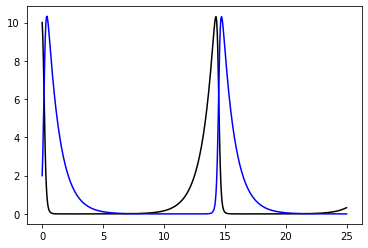

In [32]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

# Defining the derivatives of the equation.
def derivatives(t, r):
    x1, x2 = r
    dx1_t = (alpha * x1 - beta * x1 * x2)
    dx2_t = (gamma * x1 * x2 - delta * x2)
    return dx1_t, dx2_t


t = np.linspace(0, T, num_samples)

# Solve equation:
sol = integrate.solve_ivp(derivatives, (0, T), (icx1, icx2), t_eval=t)
x1_true, x2_true = sol.y
x1_true = x1_true.reshape(-1, 1)
x2_true = x2_true.reshape(-1, 1)
plt.plot(t, x1_true, color="black", label="x_true")
plt.plot(t, x2_true, color="blue", label="y_true")

Now we will try to reproduce the results presented above using the DeepXDE PINN package. And compare the results at the end.

Compiling model...
Building feed-forward neural network...
'build' took 0.033766 s

'compile' took 0.213136 s



2021-11-30 16:48:07.496176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-30 16:48:07.496283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-11-30 16:48:07.695366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Initializing variables...
Training model...

0         [1.46e-02, 1.73e-01, 1.60e+01, 4.00e+00]    [1.46e-02, 1.73e-01, 1.60e+01, 4.00e+00]    []  


2021-11-30 16:48:07.737938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 16:48:07.889398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000      [6.86e-03, 5.04e-03, 1.50e-06, 5.18e-07]    [6.93e-03, 5.04e-03, 1.50e-06, 5.18e-07]    []  
2000      [5.87e-03, 4.26e-03, 3.36e-07, 2.21e-06]    [5.92e-03, 4.25e-03, 3.36e-07, 2.21e-06]    []  
3000      [5.09e-03, 3.92e-03, 2.52e-07, 2.26e-07]    [5.13e-03, 3.91e-03, 2.52e-07, 2.26e-07]    []  
4000      [4.73e-03, 3.72e-03, 2.59e-07, 5.51e-08]    [4.77e-03, 3.71e-03, 2.59e-07, 5.51e-08]    []  
5000      [4.24e-03, 3.72e-03, 3.73e-07, 2.71e-06]    [4.27e-03, 3.72e-03, 3.73e-07, 2.71e-06]    []  
6000      [3.71e-03, 3.39e-03, 2.23e-07, 3.47e-08]    [3.74e-03, 3.39e-03, 2.23e-07, 3.47e-08]    []  
7000      [3.39e-03, 3.10e-03, 1.85e-07, 2.37e-07]    [3.42e-03, 3.09e-03, 1.85e-07, 2.37e-07]    []  
8000      [3.12e-03, 2.80e-03, 1.19e-06, 1.35e-06]    [3.14e-03, 2.80e-03, 1.19e-06, 1.35e-06]    []  
9000      [2.85e-03, 2.64e-03, 2.97e-07, 1.95e-07]    [2.87e-03, 2.64e-03, 2.97e-07, 1.95e-07]    []  
10000     [2.70e-03, 2.45e-03, 6.54e-08, 1.47e-07]    [2.72e-03, 2.45e-03

2021-11-30 16:53:17.475979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 16:53:17.526364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 16:53:17.533332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 16:53:17.657794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 16:53:17.730722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21000     [2.46e-04, 2.66e-04, 9.62e-08, 2.00e-08]                                                    
22000     [5.05e-05, 6.53e-05, 2.93e-09, 4.02e-09]                                                    
23000     [1.95e-05, 3.17e-05, 4.08e-09, 2.87e-10]                                                    
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000035
  Number of iterations: 3352
  Number of functions evaluations: 3569
23569     [1.57e-05, 1.93e-05, 3.92e-10, 2.15e-10]    [1.57e-05, 1.92e-05, 3.92e-10, 2.15e-10]    []  

Best model at step 23569:
  train loss: 3.50e-05
  test loss: 3.49e-05
  test metric: []

'train' took 115.034326 s

Saving loss history to /Users/emilhaugstvedt/Desktop/DTU/DeepLearning/PINN/loss.dat ...
Saving training data to /Users/emilhaugstvedt/Desktop/DTU/DeepLearning/PINN/train.dat ...
Saving test data to /Users/emilhaugstvedt/Desktop/DTU/DeepLearning/PINN/test.dat 

2021-11-30 16:55:12.403406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


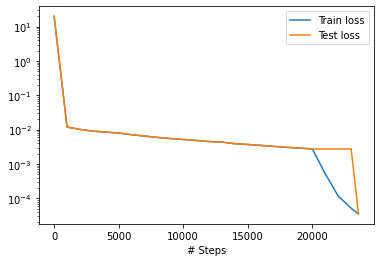

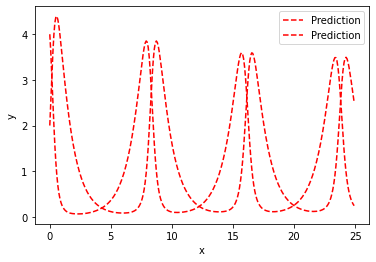

In [34]:
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

# Define the ODE-system:
def ode_system(x, y):
    x1 = y[:, 0:1]
    x2 = y[:, 1:2]
    dx1_t = dde.grad.jacobian(y, x, i=0)
    dx2_t = dde.grad.jacobian(y, x, i=1)
    return [
        dx1_t - (alpha * x1 - beta * x1 * x2),
        dx2_t - (gamma * x1 * x2 - delta * x2),
    ]

# Function for determening if x on boundary or not:
def boundary(_, on_initial):
    return on_initial

# Define the time domain of the ODE:
geom = dde.geometry.TimeDomain(0.0, T)

# Set the intial values:
ic1 = dde.IC(geom, lambda X: 4, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 2, boundary, component=1)

# Create the equation:
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 1000, 2, num_test=300)

# Define and create the neural network:
layer_size = [1] + [64] * 4 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

# Combine the data and network into a model:
model = dde.Model(data, net)

# Training:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=20000)

model.compile("L-BFGS")
losshistory, train_state = model.train()

# Plot and save
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

2021-11-27 11:22:47.238798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


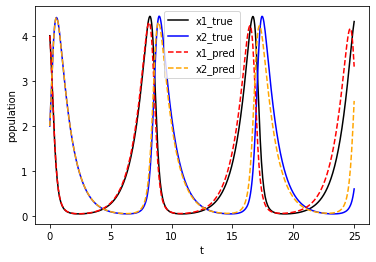

L2 relative error for x: 0.20658064314185193
L2 relative error for y: 0.18386044182582592


In [ ]:
# Plot the two solutions in the same plot:
x1_true, x2_true = sol.y
x1_true = x1_true.reshape(num_samples, 1)
x2_true = x2_true.reshape(num_samples, 1)
plt.plot(t, x1_true, color="black", label="x1_true")
plt.plot(t, x2_true, color="blue", label="x2_true")

t = t.reshape(num_samples, 1)
sol_pred = model.predict(t)
x1_pred = sol_pred[:, 0:1]
x2_pred = sol_pred[:, 1:2]

plt.xlabel("t")
plt.ylabel("population")
plt.plot(t, x1_pred, color="red", linestyle="dashed", label="x1_pred")
plt.plot(t, x2_pred, color="orange", linestyle="dashed", label="x2_pred")
plt.legend()
plt.show()

print("L2 relative error for x:", dde.metrics.l2_relative_error(x1_true, x1_pred))
print("L2 relative error for y:", dde.metrics.l2_relative_error(x2_true, x2_pred))

Now we will try to solve the inverse problem, determine the $\alpha$, $\beta$, $\delta$ and $\gamma$ just knowing the form of the equation and data produced by the equation.

In [ ]:
# Defining the variables we want to identify:
alpha = dde.Variable(0.0)
beta = dde.Variable(0.0)
delta = dde.Variable(0.0)
gamma = dde.Variable(0.0)

# Define the time domain of the ODE:
geom = dde.geometry.TimeDomain(0, 10)

# Define the ODE of the system:
def ode_system(x, y):
    x1 = y[:, 0:1]
    x2 = y[:, 1:2]
    dx1_t = dde.grad.jacobian(y, x, i=0)
    dx2_t = dde.grad.jacobian(y, x, i=1)
    return [
        dx1_t - (alpha * x1 - beta * x1 * x2),
        dx2_t - (gamma * x1 * x2 - delta * x2),
    ]

In [ ]:
# Create the boundary function to determine if x is on the boundary or not:
def boundary(_, on_initial):
    return on_initial


# Specify the intial values:
ic1 = dde.IC(geom, lambda X: 4, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 2, boundary, component=1)

In [ ]:
# Create the time vector for the known data:
t = np.reshape(np.linspace(0, T, num_samples), (num_samples, 1))

# Get the known data from the ODE solver:
x1_true, x2_true = sol.y
x = np.concatenate([x1_true.reshape(len(x1_true), 1), x2_true.reshape(len(x2_true), 1)], axis= 1)


In [ ]:
# Define the boundary conditions in the 
observe_x1 = dde.PointSetBC(t, x[:, 0:1], component= 0)
observe_x2 = dde.PointSetBC(t, x[:, 1:2], component= 1)

In [ ]:
# Define the data class:
data = dde.data.PDE(
    geom,
    ode_system,
    [ic1, ic2, observe_x1, observe_x2],
    num_domain= 100,
    num_boundary= 2,
    anchors= t)

/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "


In [ ]:
# Create neural network:
net = dde.maps.FNN([1] + [40] * 3 + [2], "tanh", "Glorot uniform")

# Combine the data and network into a model:
model = dde.Model(data, net)
model.compile("adam", lr=0.0001, external_trainable_variables=[alpha, beta, delta, gamma])

# Define when to collect the updated values of the variables and save them to a file:
variable = dde.callbacks.VariableValue(
    [alpha, beta, delta, gamma], period=600, filename="variables.dat"
)

# Train the model:
losshistory, train_state = model.train(epochs=20000, callbacks=[variable], display_every= 1000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

NameError: name 'dde' is not defined